# Neural Network Classification

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
# Dataframe of the data
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

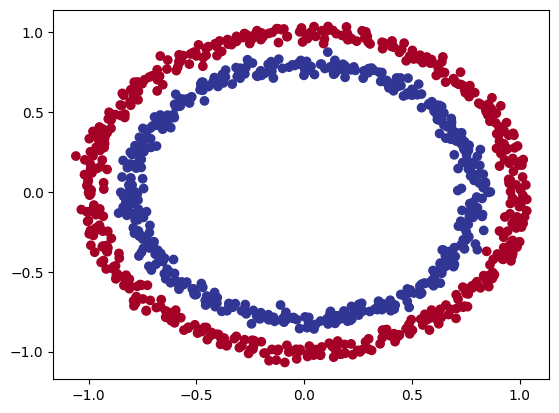

In [6]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes

In [7]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

In [11]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 Lineal layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Same model by using nn.Sequential, two layers, first layer with 2 input features and 5 output features, second layer with 5 input features and 1 output feature
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Some predictions with the model without training
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4264],
        [0.4505],
        [0.5488],
        [0.3910],
        [0.8428],
        [0.8552],
        [0.6897],
        [0.7852],
        [0.5362],
        [0.4553]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [15]:
# For loss function, we use BCELossWithLogits, which combines a sigmoid activation function and  binary cross entropy loss in one function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)  # Stochastic Gradient Descent

In [16]:
# Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

## 3. Train the Model

### 3.1 Going from raw model outputs to predicted labels

In [17]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4264],
        [0.4505],
        [0.5488],
        [0.3910],
        [0.8428]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [19]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6050],
        [0.6107],
        [0.6338],
        [0.5965],
        [0.6991]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [20]:
# Get predicted labels, either 0 or 1
y_preds = torch.round(y_pred_probs)

# Labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Difference between real labels and predicted labels
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Remove not needed dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [22]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Device setup
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training and evaluation loop
for epoc in range(epochs):
    # Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()  # Remove extra dimension
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits to predicted labels

    # Calculate loss
    loss = loss_fn(y_logits, y_train)

    # Accuracy
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_0.eval()
    with torch.inference_mode():  # Newer way for evaluation mode, instead of no_grad()
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        # Accuracy
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print numbers every 10 epochs
    if epoc % 10 == 0:
        print(
            f"Epoch [{epoc}/{epochs}] => Loss: {loss:.4f}, Accuracy: {accuracy:.4f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%")


Epoch [0/100] => Loss: 0.7458, Accuracy: 50.0000%, Test Loss: 0.7359, Test Accuracy: 50.0000%
Epoch [10/100] => Loss: 0.7095, Accuracy: 50.0000%, Test Loss: 0.7084, Test Accuracy: 50.0000%
Epoch [20/100] => Loss: 0.6983, Accuracy: 50.0000%, Test Loss: 0.7004, Test Accuracy: 50.0000%
Epoch [30/100] => Loss: 0.6949, Accuracy: 58.5000%, Test Loss: 0.6980, Test Accuracy: 52.0000%
Epoch [40/100] => Loss: 0.6938, Accuracy: 53.3750%, Test Loss: 0.6973, Test Accuracy: 46.5000%
Epoch [50/100] => Loss: 0.6934, Accuracy: 52.2500%, Test Loss: 0.6969, Test Accuracy: 47.0000%
Epoch [60/100] => Loss: 0.6933, Accuracy: 51.5000%, Test Loss: 0.6966, Test Accuracy: 46.0000%
Epoch [70/100] => Loss: 0.6932, Accuracy: 51.3750%, Test Loss: 0.6964, Test Accuracy: 47.0000%
Epoch [80/100] => Loss: 0.6931, Accuracy: 51.2500%, Test Loss: 0.6962, Test Accuracy: 46.0000%
Epoch [90/100] => Loss: 0.6931, Accuracy: 51.2500%, Test Loss: 0.6960, Test Accuracy: 46.0000%


# 4. Make predictions and evaluate the model

In [23]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [24]:
from helper_functions import plot_predictions, plot_decision_boundary

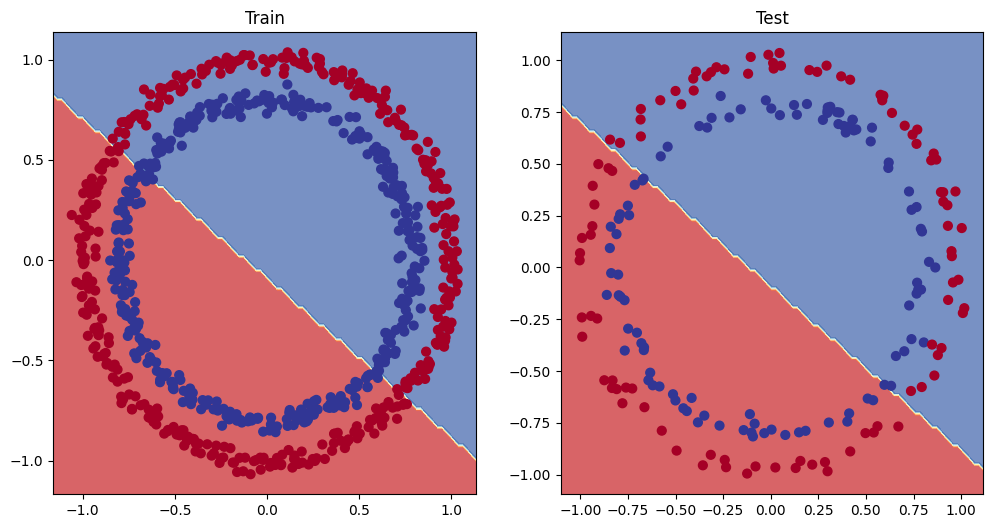

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. Improving the model

In [26]:
# Improving model with extra layers
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, X):
        return self.layer_3(self.layer_2(self.layer_1(X)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)  # Stochastic Gradient Descent

In [28]:
torch.manual_seed(42)

epochs = 1000  # Train for longer

# Device setup
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoc in range(epochs):
    # Training
    model_0.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss
    loss = loss_fn(y_logits, y_train)

    # Accuracy
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Loss
        test_loss = loss_fn(test_logits, y_test)
        # Accuracy
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print numbers every 100 epochs
    if epoc % 100 == 0:
        print(
            f"Epoch [{epoc}/{epochs}] => Loss: {loss:.4f}, Accuracy: {accuracy:.4f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%")

Epoch [0/1000] => Loss: 0.6940, Accuracy: 50.8750%, Test Loss: 0.6926, Test Accuracy: 51.0000%
Epoch [100/1000] => Loss: 0.6930, Accuracy: 50.3750%, Test Loss: 0.6938, Test Accuracy: 48.0000%
Epoch [200/1000] => Loss: 0.6930, Accuracy: 51.1250%, Test Loss: 0.6944, Test Accuracy: 46.0000%
Epoch [300/1000] => Loss: 0.6930, Accuracy: 51.6250%, Test Loss: 0.6946, Test Accuracy: 45.0000%
Epoch [400/1000] => Loss: 0.6930, Accuracy: 51.1250%, Test Loss: 0.6946, Test Accuracy: 46.0000%
Epoch [500/1000] => Loss: 0.6930, Accuracy: 51.0000%, Test Loss: 0.6947, Test Accuracy: 46.0000%
Epoch [600/1000] => Loss: 0.6930, Accuracy: 51.0000%, Test Loss: 0.6947, Test Accuracy: 46.0000%
Epoch [700/1000] => Loss: 0.6930, Accuracy: 51.0000%, Test Loss: 0.6947, Test Accuracy: 46.0000%
Epoch [800/1000] => Loss: 0.6930, Accuracy: 51.0000%, Test Loss: 0.6947, Test Accuracy: 46.0000%
Epoch [900/1000] => Loss: 0.6930, Accuracy: 51.0000%, Test Loss: 0.6947, Test Accuracy: 46.0000%


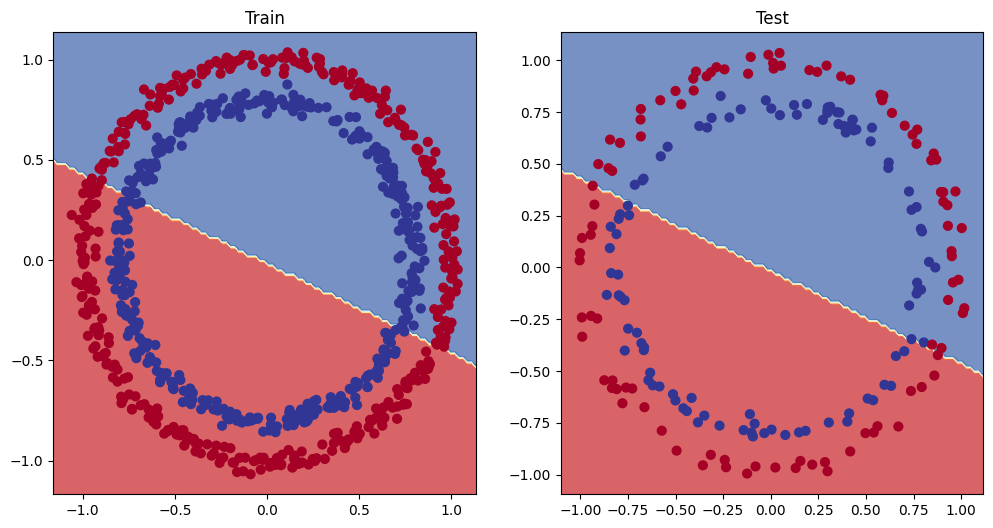

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# 6. Model without linearity

## 6.1 Non-Linear data

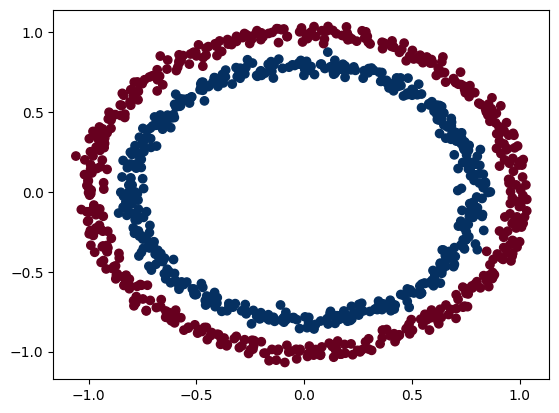

In [30]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
                    )

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [31]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building non linear model

In [32]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # Activation
        self.relu = nn.ReLU()

    def forward(self, X):
        # return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))
        Y0 = self.relu(self.layer_1(X))  # Hidden layer 1
        Y1 = self.relu(self.layer_2(Y0))  # Hidden layer 2
        Y2 = self.layer_3(Y1)  # Output layer
        return Y2


model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [33]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## 6.3 Training non-linear model

In [34]:
torch.manual_seed(42)
epochs = 1000

# Device Setup
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_3.train()

    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss
    loss = loss_fn(y_logits, y_train)

    # Accuracy
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluating
    model_3.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Loss
        test_loss = loss_fn(test_logits, y_test)
        # Accuracy
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(
            f"Epoch [{epoch}/{epochs}] => Loss: {loss:.4f}, Accuracy: {accuracy:.4f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%")

Epoch [0/1000] => Loss: 0.6929, Accuracy: 50.0000%, Test Loss: 0.6932, Test Accuracy: 50.0000%
Epoch [100/1000] => Loss: 0.6912, Accuracy: 52.8750%, Test Loss: 0.6910, Test Accuracy: 52.5000%
Epoch [200/1000] => Loss: 0.6898, Accuracy: 53.3750%, Test Loss: 0.6894, Test Accuracy: 55.0000%
Epoch [300/1000] => Loss: 0.6879, Accuracy: 53.0000%, Test Loss: 0.6872, Test Accuracy: 56.0000%
Epoch [400/1000] => Loss: 0.6852, Accuracy: 52.7500%, Test Loss: 0.6841, Test Accuracy: 56.5000%
Epoch [500/1000] => Loss: 0.6810, Accuracy: 52.7500%, Test Loss: 0.6794, Test Accuracy: 56.5000%
Epoch [600/1000] => Loss: 0.6751, Accuracy: 54.5000%, Test Loss: 0.6729, Test Accuracy: 56.0000%
Epoch [700/1000] => Loss: 0.6666, Accuracy: 58.3750%, Test Loss: 0.6632, Test Accuracy: 59.0000%
Epoch [800/1000] => Loss: 0.6516, Accuracy: 64.0000%, Test Loss: 0.6476, Test Accuracy: 67.5000%
Epoch [900/1000] => Loss: 0.6236, Accuracy: 74.0000%, Test Loss: 0.6215, Test Accuracy: 79.0000%


## 6.4 Evaluating a model trained with non-linear activation functions

In [35]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

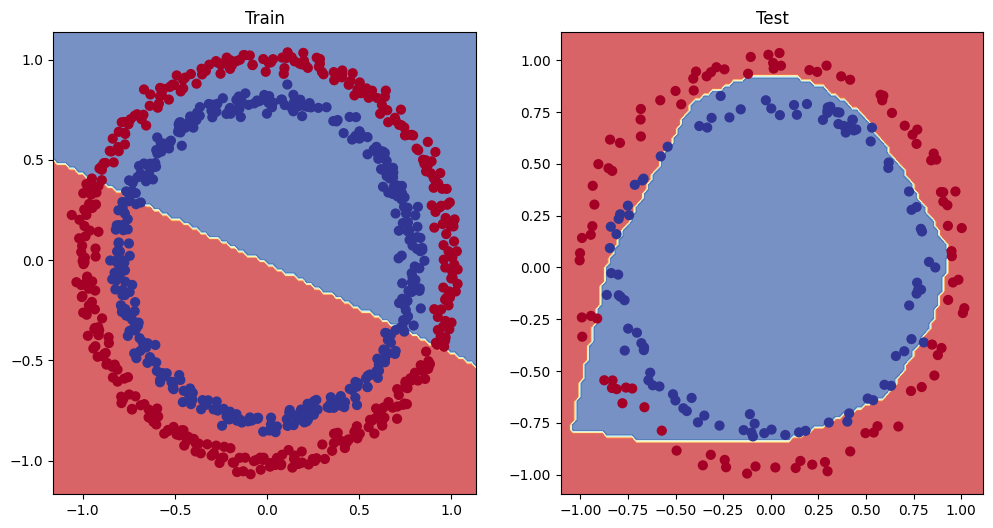

In [37]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)  # Model 1 is linear
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)  # Model 3 is non-linear

# 8. Putting things together by building a multi-class PyTorch model

## 8.1 Creating mutli-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


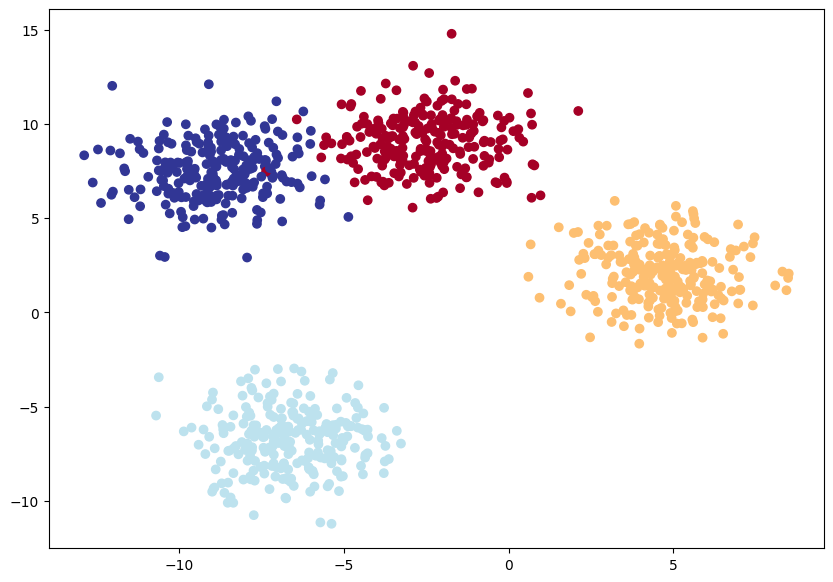

In [38]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,  # X features
    centers=NUM_CLASSES,  # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED
                                                                        )

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 8.2 Building a multi-class classification model in PyTorch

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
from torch import nn


# Build the model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units), # 2 input features, 8 hidden units
            nn.Linear(hidden_units, hidden_units), # 8 hidden units, 8 hidden units
            nn.Linear(hidden_units, output_features) # 8 hidden units, 4 output features
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


# Create an instance of the model
model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

## 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [42]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [43]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [44]:
# Prediction
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [45]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [46]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


## 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [47]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    # Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Loss and Accuracy
    loss = loss_fn(y_logits, y_blob_train)
    accuracy = accuracy_fn(y_blob_train, y_pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # Loss
        test_loss = loss_fn(test_logits, y_blob_test)
        # Accuracy
        test_accuracy = accuracy_fn(y_blob_test, test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(
            f"Epoch [{epoch}/{epochs}] => Loss: {loss:.4f}, Accuracy: {accuracy:.4f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%")


Epoch [0/100] => Loss: 1.0432, Accuracy: 65.5000%, Test Loss: 0.5786, Test Accuracy: 95.5000%
Epoch [10/100] => Loss: 0.1440, Accuracy: 99.1250%, Test Loss: 0.1304, Test Accuracy: 99.0000%
Epoch [20/100] => Loss: 0.0806, Accuracy: 99.1250%, Test Loss: 0.0722, Test Accuracy: 99.5000%
Epoch [30/100] => Loss: 0.0592, Accuracy: 99.1250%, Test Loss: 0.0513, Test Accuracy: 99.5000%
Epoch [40/100] => Loss: 0.0489, Accuracy: 99.0000%, Test Loss: 0.0410, Test Accuracy: 99.5000%
Epoch [50/100] => Loss: 0.0429, Accuracy: 99.0000%, Test Loss: 0.0349, Test Accuracy: 99.5000%
Epoch [60/100] => Loss: 0.0391, Accuracy: 99.0000%, Test Loss: 0.0308, Test Accuracy: 99.5000%
Epoch [70/100] => Loss: 0.0364, Accuracy: 99.0000%, Test Loss: 0.0280, Test Accuracy: 99.5000%
Epoch [80/100] => Loss: 0.0345, Accuracy: 99.0000%, Test Loss: 0.0259, Test Accuracy: 99.5000%
Epoch [90/100] => Loss: 0.0330, Accuracy: 99.1250%, Test Loss: 0.0242, Test Accuracy: 99.5000%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [48]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [49]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


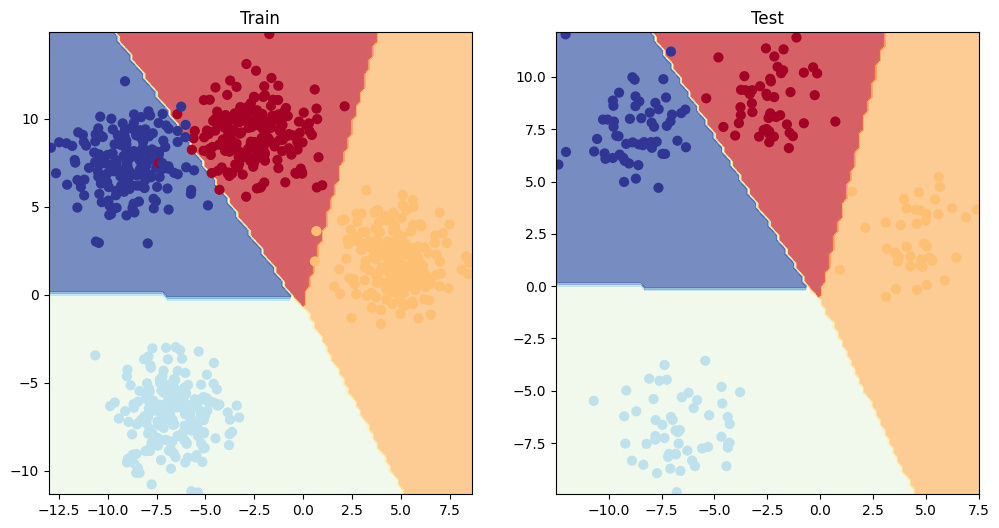

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# 9. Metrics

In [51]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')